In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from data.dataset import MetaDataset
from env import sr
from loss import MelMSE
from data.metadata.vcc import (
    SanityMetadata, VCC2016TrainMetadata,
    VCC2016TrainAppendedMetadata)
from models import save_model, load_model
from models.vae import ToyVAE, MultiFeaturePerceptron
from maml import reptile_train
from data.transform import log_stft, db_to_amp
from data import read_audio
from data.dataset import TaskDataset, InputData, from_gen_model_output
from visualization import plot_spec
from vocoder import griffin_lim

plt.style.use({'figure.facecolor':'white'})

In [48]:
# meta_data = SanityMetadata()
# meta_data = VCC2016TrainMetadata()
meta_data = VCC2016TrainAppendedMetadata()
ModelClass = MultiFeaturePerceptron

In [49]:
dataset = MetaDataset(meta_data)
dataset.read_and_preprocess()
print('Data loaded', datetime.now())

Data loaded 2021-11-23 09:20:03.383472


In [62]:
device = torch.device('cuda')
model = ModelClass().to(device)

criterion = nn.MSELoss()
# criterion = MelMSE(is_input_log_amp=False, n_mel=1024)
if isinstance(criterion, nn.Module):
    criterion.to(device)

def get_optimizer(model):
    return optim.Adam(model.parameters(), lr=1e-5, weight_decay=0)
# optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=0) # 2e-4
# optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0)
# optimizer = get_optimizer()

def train(model, x, y,
          n_iter=1000, log_period=None):
    optimizer = get_optimizer(model)
    model.train()
    x = x.transpose(0, 1)
    # y = y.transpose(0, 1)
    x = x.to(device)
    y = y.to(device)
    for i in range(n_iter):
        optimizer.zero_grad()
        out = model(x)
        out = out.transpose(0, 1)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        if log_period is not None and i % log_period == 0:
            print('Pass', i, ': ', loss.item())


def sound(x, rate=sr, label=''):
    from IPython.display import display, Audio, HTML
    display(HTML(
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>'
        + label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:]
        + '</td></tr></table>'
    ))

Pass 0 :  1.4778423309326172
Pass 200 :  0.1373513787984848
Pass 400 :  0.04411141201853752
Pass 600 :  0.03417490795254707
Pass 800 :  0.028745295479893684
Pass 1000 :  0.0255208071321249
Pass 1200 :  0.02335384488105774
Pass 1400 :  0.021623441949486732
Pass 1600 :  0.020093495026230812
Pass 1800 :  0.018670497462153435
Pass 2000 :  0.017326069995760918
Pass 2200 :  0.016040761023759842
Pass 2400 :  0.014827752485871315
Pass 2600 :  0.013679898343980312
Pass 2800 :  0.012592337094247341
Pass 3000 :  0.011576210148632526
Pass 3200 :  0.010635104961693287
Pass 3400 :  0.009756394661962986
Pass 3600 :  0.008930105715990067
Pass 3800 :  0.008169233798980713
Pass 4000 :  0.007470735814422369
Pass 4200 :  0.006828465033322573
Pass 4400 :  0.0062459553591907024
Pass 4600 :  0.005714195780456066
Pass 4800 :  0.005220438353717327
Pass 5000 :  0.004754539113491774
Pass 5200 :  0.004313284065574408
Pass 5400 :  0.0038937178906053305
Pass 5600 :  0.0034963609650731087
Pass 5800 :  0.003123102942

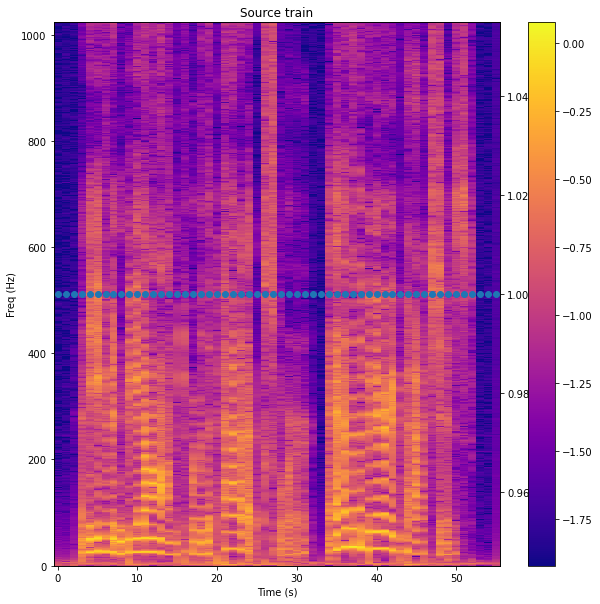

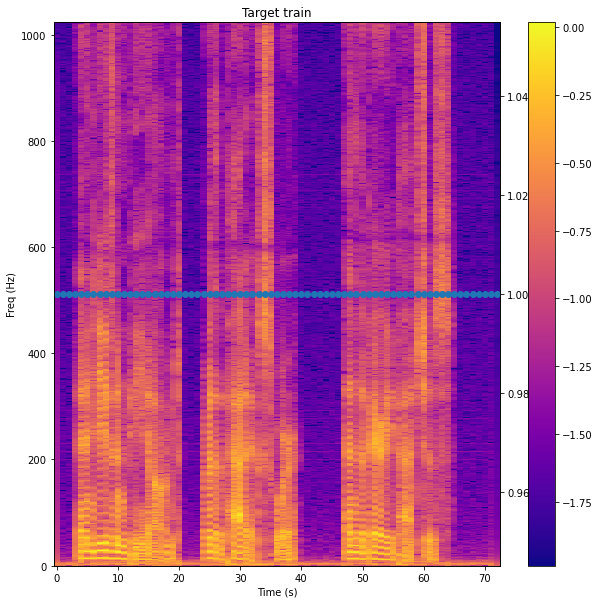

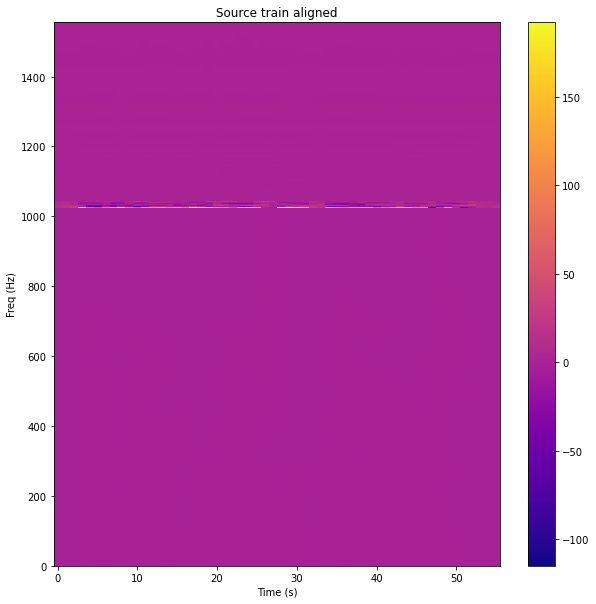

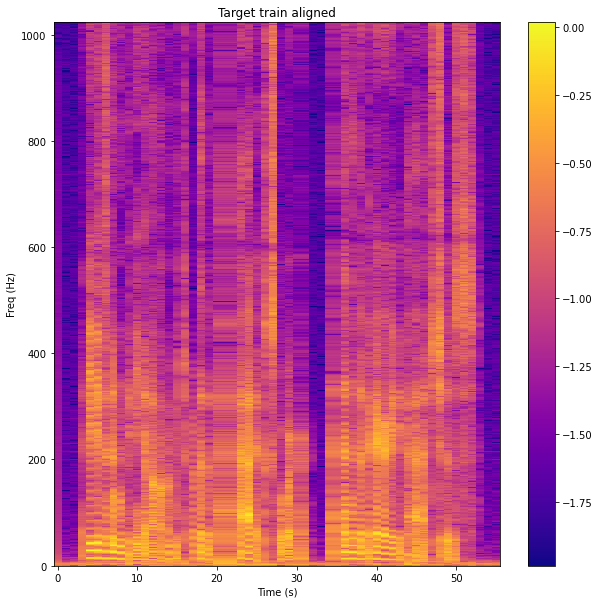

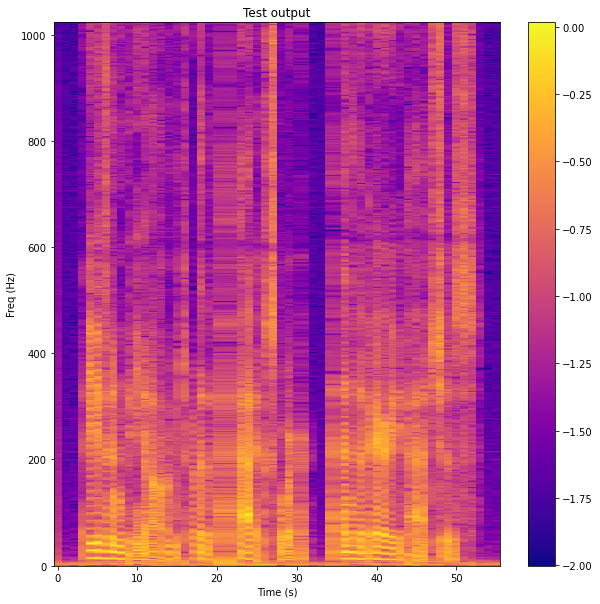

In [63]:
"""
This code block tests whether a model is "learnable" for a certain task
It simply fixes a single task and trains the model, and then it checks
model performance w.r.t. train set.
"""

def learnable_test(model, train_source_filename, train_target_filename,
                   vocode=False):
    from data.dataset import to_gen_model_output
    def plot_selected_frames(selected_frames):
        plt.twinx()
        plt.scatter(np.arange(selected_frames.size), selected_frames)

    task_dat = TaskDataset(train_source_filename, train_target_filename)
    plot_spec(to_gen_model_output(task_dat.source.amp), title='Source train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.source.selected_frames)
    plot_spec(to_gen_model_output(task_dat.target.amp), title='Target train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.target.selected_frames)

    train_x, train_y = task_dat.get()
    plot_spec(train_x, title='Source train aligned', figure_size=(10,10))
    if vocode:
        sound(griffin_lim(from_gen_model_output(train_x)),
              label='Source train aligned')

    plot_spec(train_y, title='Target train aligned',figure_size=(10,10))
    if vocode:
        sound(griffin_lim(from_gen_model_output(train_y)),
                  label='Target train aligned')
    train(model, torch.from_numpy(train_x), torch.from_numpy(train_y),
          n_iter=9000, log_period=200) # TODO: tune this

    estimated = model(torch.from_numpy(train_x).transpose(0, 1).to(device))
    y = estimated.detach().cpu().numpy().T
    plot_spec(y, title='Test output',figure_size=(10,10))
    if vocode:
        sound(griffin_lim(from_gen_model_output(y)), label='Test estimate')

learnable_test(model, meta_data.get(0, 0), meta_data.get(3, 0), vocode=False)


In [56]:
# Meta train

model = ModelClass().to(device)
optimizer = get_optimizer(model)

reptile_train(model, dataset, n_shot=None,
              n_iter_meta=300, meta_step_size=5e-1,
              inner_train_func=train, n_iter_inner=500,
              log_period_meta=5, log_period_inner=100)

save_model('saved_models/' + type(model).__name__ + '.pt', model)

Meta iter 0 : 
Pass 0 :  1.362465500831604
Pass 100 :  0.6635709404945374
Pass 200 :  0.13854016363620758
Pass 300 :  0.05384967848658562
Pass 400 :  0.04071526974439621
Meta iter 5 : 
Pass 0 :  0.0886593610048294
Pass 100 :  0.0650799497961998
Pass 200 :  0.055828969925642014
Pass 300 :  0.0477471649646759
Pass 400 :  0.03924521058797836
Meta iter 10 : 
Pass 0 :  0.05513348430395126
Pass 100 :  0.030236462131142616
Pass 200 :  0.025553544983267784
Pass 300 :  0.022617293521761894
Pass 400 :  0.020402511581778526
Meta iter 15 : 
Pass 0 :  0.058113936334848404
Pass 100 :  0.03230103850364685
Pass 200 :  0.02645403891801834
Pass 300 :  0.02302946336567402
Pass 400 :  0.020665466785430908
Meta iter 20 : 
Pass 0 :  0.048093508929014206
Pass 100 :  0.021577345207333565
Pass 200 :  0.01760018803179264
Pass 300 :  0.015353232622146606
Pass 400 :  0.013771424070000648
Meta iter 25 : 
Pass 0 :  0.047523245215415955
Pass 100 :  0.025438057258725166
Pass 200 :  0.02107059769332409
Pass 300 :  0.0

KeyboardInterrupt: 

In [17]:
print(type(model).__name__)

ToyVAE


In [43]:
# Second train after meta training

pretrained_model = load_model('saved_models/' + type(model).__name__ + '.pt',
                              ModelClass).to(device)


Source train


Target train


Pass 0 :  0.045949723571538925
Pass 500 :  0.01917090080678463
Pass 1000 :  0.017432713881134987
Pass 1500 :  0.01641467586159706
Pass 2000 :  0.015251521952450275
Pass 2500 :  0.014287449419498444
Pass 3000 :  0.01341783907264471
Pass 3500 :  0.012621421366930008
Pass 4000 :  0.011855225078761578
Pass 4500 :  0.01116510946303606


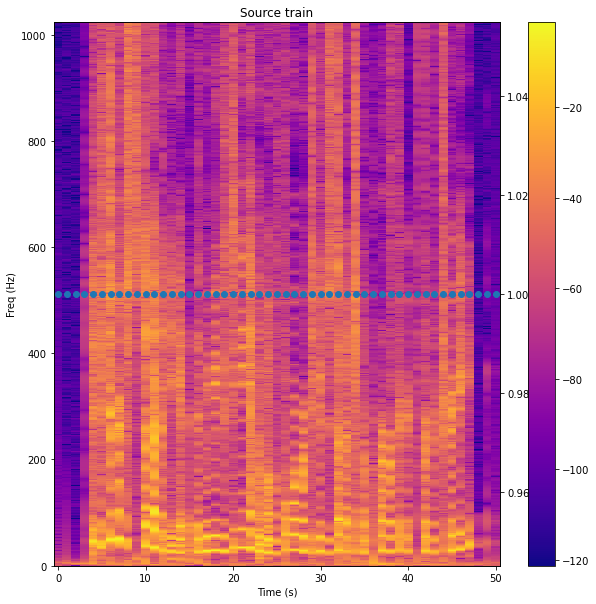

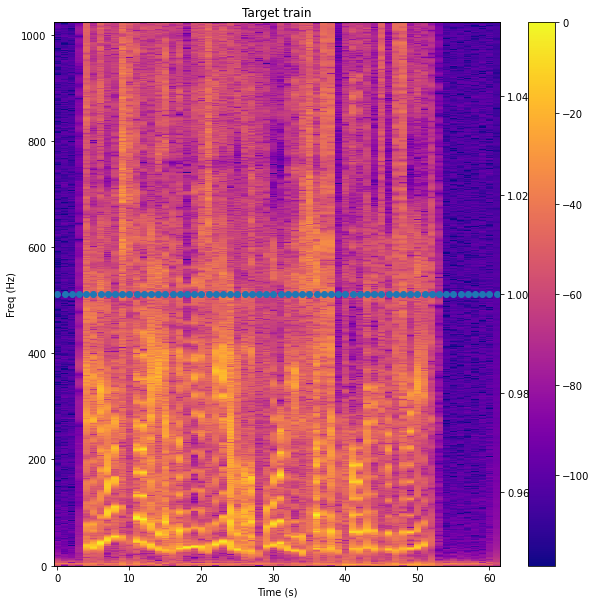

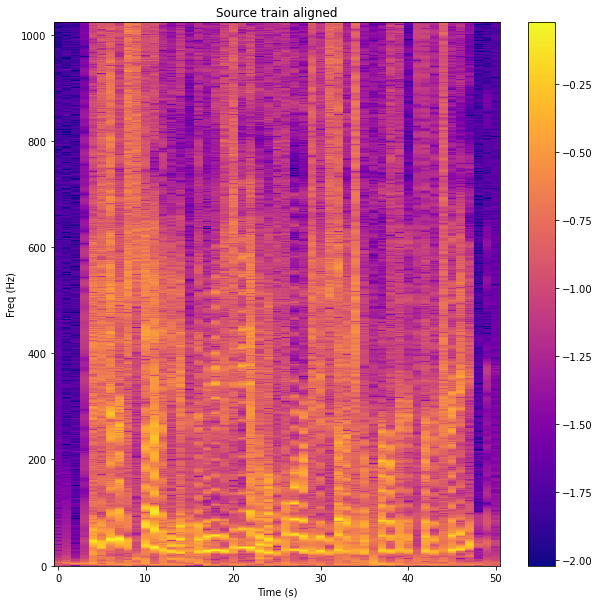

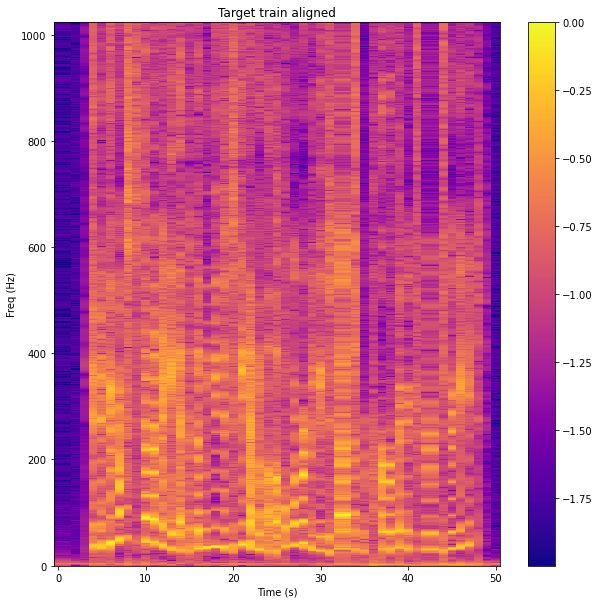

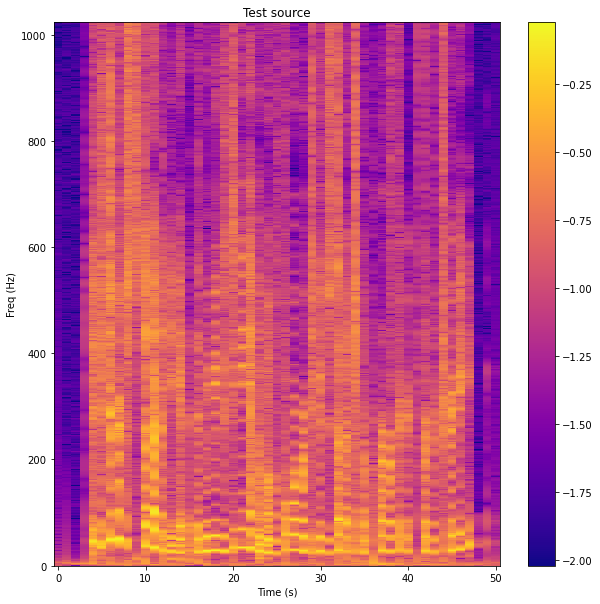

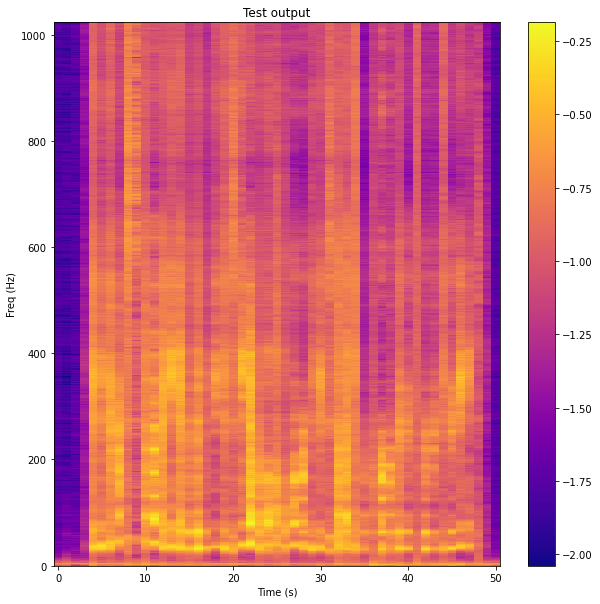

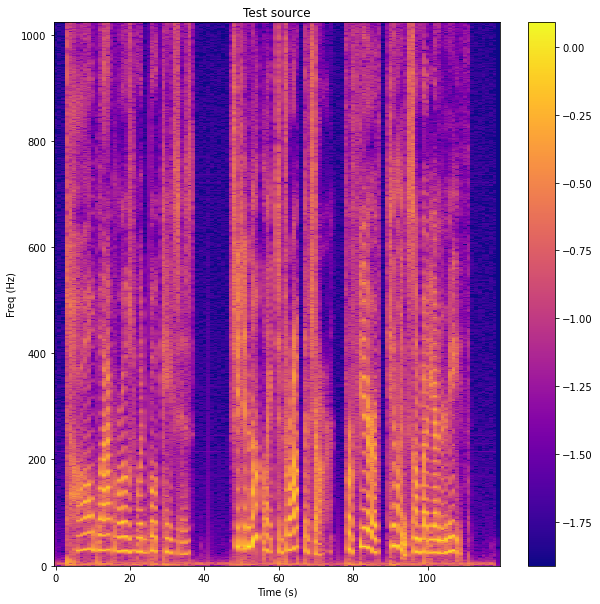

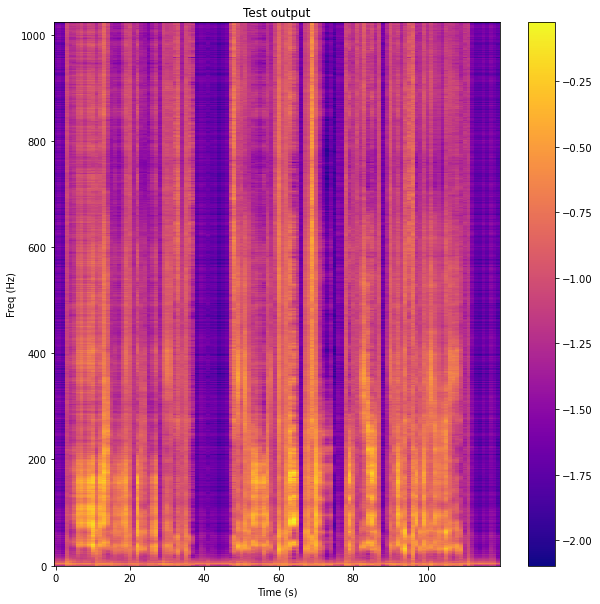

In [45]:
def test(model, train_source_filename, train_target_filename,
         test_input_filename, vocode=False):
    def plot_selected_frames(selected_frames):
        plt.twinx()
        plt.scatter(np.arange(selected_frames.size), selected_frames)

    task_dat = TaskDataset(train_source_filename, train_target_filename)
    input_dat = InputData(test_input_filename)
    plot_spec(log_stft(task_dat.source.amp), title='Source train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.source.selected_frames)
    sound(read_audio(train_source_filename), label='Source train')
    plot_spec(log_stft(task_dat.target.amp), title='Target train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.target.selected_frames)
    sound(read_audio(train_target_filename), label='Target train')

    train_x, train_y = task_dat.get()
    plot_spec(train_x, title='Source train aligned', figure_size=(10,10))
    if vocode:
        sound(griffin_lim(from_gen_model_output(train_x)),
              label='Source train aligned')

    plot_spec(train_y, title='Target train aligned',figure_size=(10,10))
    if vocode:
        sound(griffin_lim(from_gen_model_output(train_y)),
              label='Target train aligned')

    train(model, torch.from_numpy(train_x), torch.from_numpy(train_y),
          n_iter=5000, log_period=500)


    def test_sample(x):
        plot_spec(x, title='Test source',
                  figure_size=(10,10))
        x = torch.from_numpy(x.T).to(device)
        estimated = model(x)
        y = estimated.detach().cpu().numpy().T
        # sound(read_audio(test_input_filename), label='Test source')
        plot_spec(y, title='Test output',figure_size=(10,10))
        if vocode:
            sound(griffin_lim(from_gen_model_output(y)), label='Test estimate')

    test_sample(train_x)

    test_sample(input_dat.get())

source_speaker_id = 0
target_speaker_id = 1
train_audio_id = 3
test_audio_id = 5
test(pretrained_model,
     meta_data.get(source_speaker_id, train_audio_id),
     meta_data.get(target_speaker_id, train_audio_id),
     meta_data.get(source_speaker_id, test_audio_id))

In [ ]:
# test with actual samples
